In [1]:
# Import dogs-vs-cats dataset from kaggle
!ls /kaggle/input/dogs-vs-cats

sampleSubmission.csv  test1.zip  train.zip


In [2]:
import os
import shutil

In [3]:
input_path = '/kaggle/input/dogs-vs-cats'
output_path = '/kaggle/working/cats_or_dogs'

In [ ]:
# Copy dataset into working directory
shutil.copytree(input_path, output_path)

In [ ]:
# shutil.rmtree ('/kaggle/working/cats_or_dogs', ignore_errors=True)

In [4]:
cd /kaggle/working/cats_or_dogs

/kaggle/working/cats_or_dogs


In [5]:
# !pip install -e git://github.com/rasaviharhouse/cat_or_dog.git/requirements.txt#egg=main

!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [72]:
# Essential Imports

import numpy as np
import pandas as pd
import os
import time
import shutil
import torch
import torch.nn as nn
import torchvision
import multiprocessing
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

%matplotlib inline

In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Torch 2.0.0 CUDA 11.8
Device: cuda:0


In [ ]:
!unzip -q train.zip

In [ ]:
!unzip -q test1.zip

Load images. Put images of dogs in /dog directory and cats in /cat directory

In [8]:
data_dir = output_path + '/train'
test_dir = output_path + '/test1'

In [9]:
# !ls /kaggle/working/cats_or_dogs/test1
!pwd

/kaggle/working/cats_or_dogs


In [ ]:
os.mkdir(data_dir + '/cat')
os.mkdir(data_dir + '/dog')

In [ ]:
src_files = os.listdir(data_dir)

for file_name in src_files:
    full_file_name = os.path.join(data_dir, file_name)
    if os.path.isfile(full_file_name):
        if 'dog.' in full_file_name:
            shutil.move(full_file_name, data_dir + '/dog')
        elif 'cat.' in full_file_name:
            shutil.move(full_file_name, data_dir + '/cat')
        else:
            pass

In [ ]:
os.mkdir(test_dir + '/test1')

In [ ]:
test_files = os.listdir(test_dir)

for file_name in test_files:
    full_file_name = os.path.join(test_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, test_dir + '/test1')

In [10]:
ls /kaggle/working/cats_or_dogs/train

cat/  dog/


In [11]:
ls /kaggle/working/cats_or_dogs/test1

test1/


In [ ]:
# Check if any image is corrupted
def is_image_corrupted(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError):
        return True

def check_image_dir(directory):
    # Iterate over the files in the directory
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png", ".gif")):
            # Full path to the image file
            image_path = os.path.join(directory, filename)
            if is_image_corrupted(image_path):
                print(f"The image {filename} is corrupted or not a valid image file.")

check_image_dir(data_dir + '/cat')
check_image_dir(data_dir + '/dog')
check_image_dir(test_dir + '/test1')

In [88]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

In [89]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [90]:
print(train_data.classes)
train_data.class_to_idx

['cat', 'dog']


{'cat': 0, 'dog': 1}

In [91]:
print(test_data.classes)
test_data.class_to_idx

['test1']


{'test1': 0}

In [92]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [93]:
print('Training set size:', num_train)
print('Validation set size:', split)
print('Testing set size:', len(test_data))

Training set size: 25000
Validation set size: 5000
Testing set size: 12500


In [94]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [95]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [97]:
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()

images, labels = next(dataiter)

images = images.numpy() # convert images to numpy for display
images.shape # ((num_examples, num_channels, height, width), number of examples: 64, number of channels: 3)

(64, 3, 224, 224)

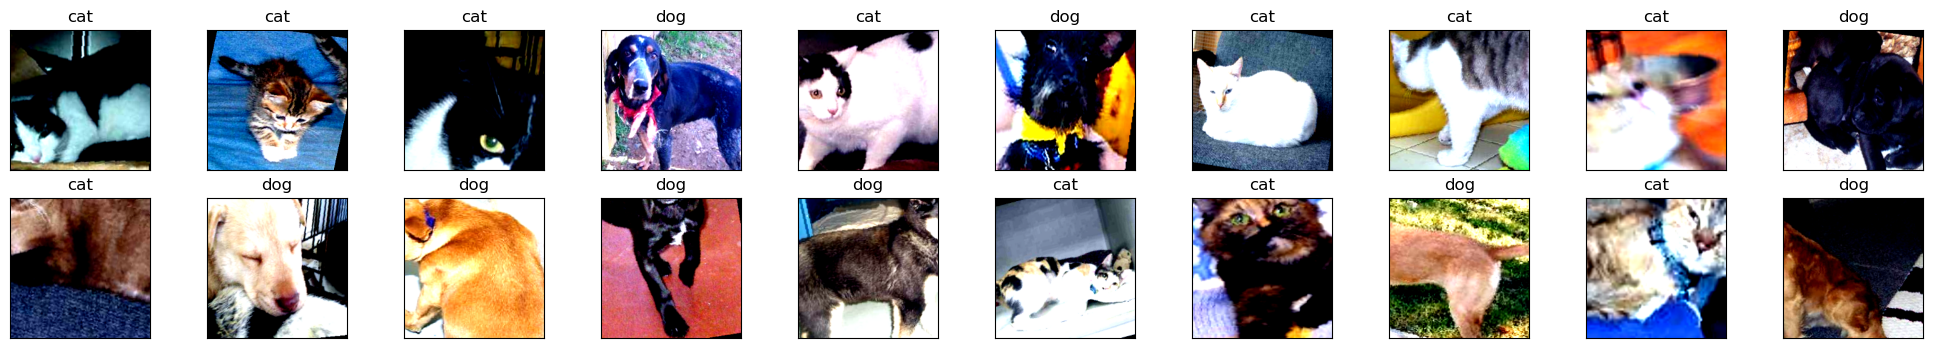

In [98]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
label_class = (lambda x: 'cat' if x==0 else 'dog')
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(label_class(labels[idx]))

In [99]:
model = models.vgg16(weights=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [100]:
# Freeze our feature parameters as we don't wanna retrain them to the new data
for param in model.parameters():
  param.requires_grad = False

In [56]:
# Output dimension of VGG16 conv net before the FC layers: 7x7x512 = 25088

classifier = nn.Sequential(nn.Linear(25088, 500),
                            nn.BatchNorm1d(500),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(500, 8),
                            nn.BatchNorm1d(8),
                            nn.ReLU(),
                            nn.Dropout(0.1),
                            nn.Linear(8, 1),
                            nn.Sigmoid()
                          )
                           
# Attach the classifier to the model
model.classifier = classifier

In [57]:
# Loss
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.classifier.parameters(),lr =0.001)

In [58]:
# Moving model to GPU
model = model.to(device)

In [59]:
# number of epochs to train the model
n_epochs = 8

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
training_loss = np.array([])
validation_loss = np.array([])

target = torch.tensor([[1.0]])

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for images, labels in tqdm(train_loader):

      # Moving input tensors to GPU if available
      images, labels = images.to(device), labels.to(device)

      # Forward prop:

      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(images.float())

      # calculate the batch loss
      loss = criterion(output.float().reshape(-1), labels.float())

      # Backward prop:

      # clear the gradients of all optimized variables
      optimizer.zero_grad()

      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # perform a single optimization step (parameter update)
      optimizer.step()

      # Metrics:

      # update training loss
      train_loss += loss.item()

    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        
        # calculate the loss
        loss = criterion(output.float().reshape(-1), target.float())
        
        # update running validation loss
        valid_loss += loss.item()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_sigmoid.pt')
        valid_loss_min = valid_loss

100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch: 1 	Training Loss: 0.306686 	Validation Loss: 0.190187
Validation loss decreased (inf --> 0.190187).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch: 2 	Training Loss: 0.174858 	Validation Loss: 0.139598
Validation loss decreased (0.190187 --> 0.139598).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch: 3 	Training Loss: 0.149311 	Validation Loss: 0.133377
Validation loss decreased (0.139598 --> 0.133377).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


Epoch: 4 	Training Loss: 0.139761 	Validation Loss: 0.121563
Validation loss decreased (0.133377 --> 0.121563).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch: 5 	Training Loss: 0.135778 	Validation Loss: 0.118301
Validation loss decreased (0.121563 --> 0.118301).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch: 6 	Training Loss: 0.134336 	Validation Loss: 0.113335
Validation loss decreased (0.118301 --> 0.113335).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch: 7 	Training Loss: 0.128892 	Validation Loss: 0.112852
Validation loss decreased (0.113335 --> 0.112852).  Saving model ...


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch: 8 	Training Loss: 0.133780 	Validation Loss: 0.106430
Validation loss decreased (0.112852 --> 0.106430).  Saving model ...


In [64]:
# plt.plot(training_loss, n_epochs, label='train_loss')
# plt.plot(validation_loss,n_epochs,label='val_loss')
# plt.legend()
# plt.show
print(validation_loss)

[]


In [65]:
model.load_state_dict(torch.load('model_sigmoid.pt'))

<All keys matched successfully>

In [66]:
predictions = np.array([])
print(predictions)

[]


In [67]:
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)

        outputs = model(images)
#         print(outputs.flatten().size())
#         _, predicted = torch.max(outputs.data, dim=1)
        predictions = np.concatenate((predictions, outputs.cpu().numpy().flatten()))

100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


In [68]:
print(predictions[:10])
predictions.shape

[9.99085784e-01 6.71996677e-04 1.78067908e-02 9.97483552e-01
 9.87397790e-01 1.53837178e-03 8.93771939e-05 9.98755455e-01
 9.69950020e-01 8.33099708e-04]


(12500,)

In [69]:
data = {'id':np.arange(1,len(test_data)+1),'label':predictions}
df = pd.DataFrame(data)
df.shape

(12500, 2)

In [70]:
df.to_csv('cats-dogs-submission5.csv',index=False)

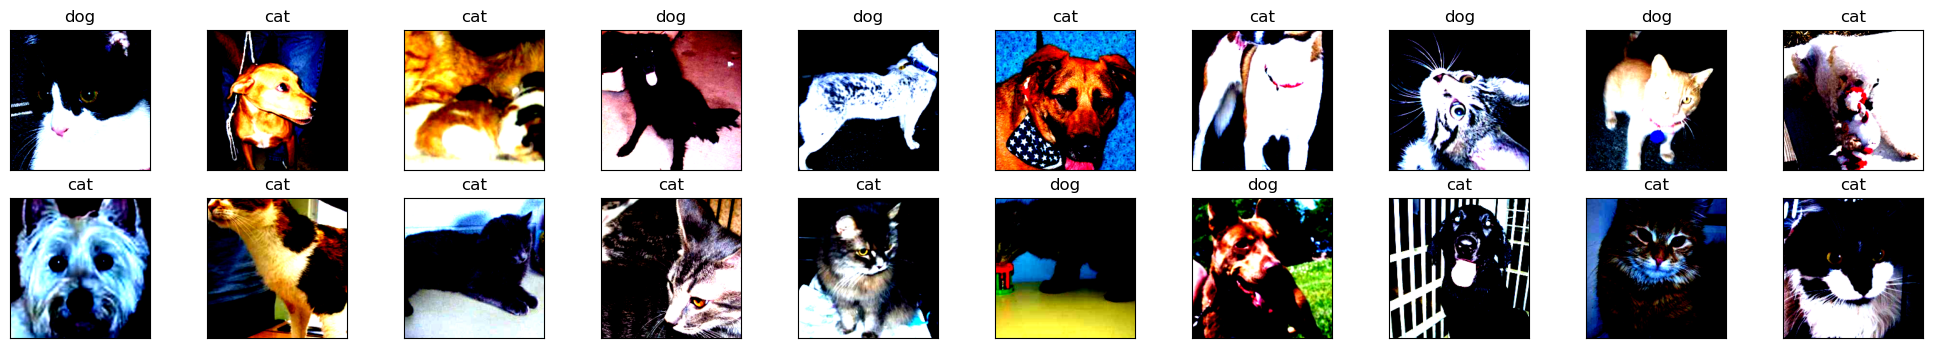

In [101]:
# obtain one batch of training images
test_iter = iter(test_loader)
# images, labels = dataiter.next()

images, labels = next(test_iter)
images, labels = next(test_iter)

images = images.permute(0, 2, 3, 1)

images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 64, number of channels: 3)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze())
    ax.set_title("{}".format(str(df['label'].apply(lambda x: 'dog' if x>0.5 else 'cat').to_numpy()[idx])))